In [1]:
# Initial imports
import os
import csv
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
from pathlib import Path
import datetime as dt

#Subsequent imports
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Enable the Matplotlib property to allow diagrams to display in Jupyter Notebook
%matplotlib inline

In [2]:
# List the ticker symbols for the stocks of interest
lst_Stocks = ['BMO.TO', 'BNS.TO', 'CM.TO', 'NA.TO','RY.TO', 'TD.TO', 'ZEB.TO','ZWB.TO', 'XGB.TO', 'CL' ]
ticker = ['BMO.TO']

# Determine the Date range for the desired data
start_date = '2014-01-01'
end_date = '2022-12-31'
df = yf.download(ticker, start= start_date, end= end_date)
df = df.sort_index()


[*********************100%***********************]  1 of 1 completed


In [3]:
# Feature Engineering

# Mid Rang Variables
df['Mid_hl'] = (df['High'] + df['Low']) /2 
df['Mid_oc'] = (df['Open'] + df['Close']) /2 
df['Mid_hloc'] = (df['High'] + df['Low'] + df['Open'] + df['Close']) /4 

# Close in Range ==> Close at Low = 0, Close at High = 1
df['Close_in_range'] = 1 - ((df['High'] - df['Close']) / (df['High'] - df['Low']) )

# Daily/Weekly Returns - Average of Open and Close
df['Returns_1Day_Moc'] = df['Mid_oc'].pct_change()
df['Returns_5Day_Moc'] = df['Mid_oc'].pct_change(5)
df['Returns_30Day_Moc'] = df['Mid_oc'].pct_change(30)

# Daily/Weekly Returns - Average of High Low Open Close
df['Returns_1Day_Mhloc'] = df['Mid_hloc'].pct_change()
df['Returns_5Day_Mhloc'] = df['Mid_hloc'].pct_change(5)
df['Returns_30Day_Mhloc'] = df['Mid_hloc'].pct_change(30)

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Moc'] = df['Mid_oc'].rolling(10).std()
df['Std_Dev_30Day_Moc'] = df['Mid_oc'].rolling(30).std()

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Mhloc'] = df['Mid_hloc'].rolling(10).std()
df['Std_Dev_30Day_Mhloc'] = df['Mid_hloc'].rolling(30).std()

# Simple Moving Average - 8 Day vs 20 Day
df['SMA_Returns_8Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(8).std()
df['SMA_Returns_20Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(20).std()
df['SMA_Delta_8_20Day_Mhloc'] = df['SMA_Returns_8Day_Mhloc'] - df['SMA_Returns_20Day_Mhloc']
df['SMA_Signal_8_20Day_Mhloc'] = np.where(df['SMA_Returns_8Day_Mhloc'] < 1, 0, 1) 

# Display
display(df.columns)
display(df.head(10))
display(df.tail(10))

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mid_hl',
       'Mid_oc', 'Mid_hloc', 'Close_in_range', 'Returns_1Day_Moc',
       'Returns_5Day_Moc', 'Returns_30Day_Moc', 'Returns_1Day_Mhloc',
       'Returns_5Day_Mhloc', 'Returns_30Day_Mhloc', 'Std_Dev_10Day_Moc',
       'Std_Dev_30Day_Moc', 'Std_Dev_10Day_Mhloc', 'Std_Dev_30Day_Mhloc',
       'SMA_Returns_8Day_Mhloc', 'SMA_Returns_20Day_Mhloc',
       'SMA_Delta_8_20Day_Mhloc', 'SMA_Signal_8_20Day_Mhloc'],
      dtype='object')

Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  70.680000  70.779999  70.300003  70.730003   
2014-01-03 00:00:00-05:00  70.790001  71.250000  70.739998  71.040001   
2014-01-06 00:00:00-05:00  71.279999  71.300003  70.599998  70.839996   
2014-01-07 00:00:00-05:00  71.029999  71.279999  70.940002  70.940002   
2014-01-08 00:00:00-05:00  71.089996  71.220001  70.629997  71.000000   
2014-01-09 00:00:00-05:00  71.199997  71.370003  70.769997  71.209999   
2014-01-10 00:00:00-05:00  71.389999  71.519997  71.099998  71.349998   
2014-01-13 00:00:00-05:00  71.300003  71.879997  71.300003  71.699997   
2014-01-14 00:00:00-05:00  71.910004  71.980003  71.519997  71.599998   
2014-01-15 00:00:00-05:00  71.849998  72.080002  71.580002  71.739998   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  48.488052   983600  70.540001  70.705002   
2014-01-03 00:00:00-05:00  48.700581  1233400  70.994999  70.915001   
2014-01-06 00:00:00-05:00  48.563465  1351800  70.950001  71.059998   
2014-01-07 00:00:00-05:00  48.632042  1035600  71.110001  70.985001   
2014-01-08 00:00:00-05:00  48.673157  1062000  70.924999  71.044998   
2014-01-09 00:00:00-05:00  48.817116   914600  71.070000  71.204998   
2014-01-10 00:00:00-05:00  48.913097  1378900  71.309998  71.369999   
2014-01-13 00:00:00-05:00  49.153030  1122400  71.590000  71.500000   
2014-01-14 00:00:00-05:00  49.084488  1020900  71.750000  71.755001   
2014-01-15 00:00:00-05:00  49.180443  1141500  71.830002  71.794998   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2014-01-02 00:00:00-05:00  70.622501        0.895842  ...                 NaN   
2014-01-03 00:00:00-05:00  70.955000        0.588239  ...                 NaN   
2014-01-06 00:00:00-05:00  71.004999        0.342852  ...                 NaN   
2014-01-07 00:00:00-05:00  71.047501        0.000000  ...                 NaN   
2014-01-08 00:00:00-05:00  70.984999        0.627119  ...                 NaN   
2014-01-09 00:00:00-05:00  71.137499        0.733330  ...            0.007292   
2014-01-10 00:00:00-05:00  71.339998        0.595241  ...            0.005426   
2014-01-13 00:00:00-05:00  71.545000        0.689652  ...            0.007605   
2014-01-14 00:00:00-05:00  71.752501        0.173914  ...            0.009923   
2014-01-15 00:00:00-05:00  71.812500        0.319992  ...            0.011657   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2014-01-02 00:00:00-05:00                  NaN                NaN   
2014-01-03 00:00:00-05:00                  NaN                NaN   
2014-01-06 00:00:00-05:00                  NaN                NaN   
2014-01-07 00:00:00-05:00                  NaN                NaN   
2014-01-08 00:00:00-05:00                  NaN                NaN   
2014-01-09 00:00:00-05:00                  NaN                NaN   
2014-01-10 00:00:00-05:00                  NaN                NaN   
2014-01-13 00:00:00-05:00                  NaN                NaN   
2014-01-14 00:00:00-05:00                  NaN                NaN   
2014-01-15 00:00:00-05:00                  NaN           0.362989   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2014-01-02 00:00:00-05:00                NaN                  NaN   
2014-01-03 00:00:00-05:00                NaN                  NaN   
2014-01-06 00:00:00-05:00                NaN                  NaN   
2014-01-07 00:00:00-05:00                NaN                  NaN   
2014-01-08 00:00:00-05:00                NaN                  NaN   
2014-01-09 00:00:

Open        High         Low       Close  \
Date                                                                        
2022-12-15 00:00:00-05:00  121.070000  122.080002  120.080002  120.750000   
2022-12-16 00:00:00-05:00  119.959999  121.160004  119.800003  120.629997   
2022-12-19 00:00:00-05:00  120.779999  121.809998  119.519997  120.089996   
2022-12-20 00:00:00-05:00  120.709999  122.290001  120.580002  121.680000   
2022-12-21 00:00:00-05:00  122.779999  124.059998  122.669998  123.110001   
2022-12-22 00:00:00-05:00  122.750000  122.930000  121.029999  122.089996   
2022-12-23 00:00:00-05:00  122.190002  122.769997  121.580002  122.690002   
2022-12-28 00:00:00-05:00  122.779999  123.290001  121.650002  122.010002   
2022-12-29 00:00:00-05:00  122.559998  123.660004  122.440002  123.449997   
2022-12-30 00:00:00-05:00  122.849998  123.559998  122.230003  122.660004   

                            Adj Close   Volume      Mid_hl      Mid_oc  \
Date                                                                     
2022-12-15 00:00:00-05:00  119.473213  2053100  121.080002  120.910000   
2022-12-16 00:00:00-05:00  119.354477  5149500  120.480003  120.294998   
2022-12-19 00:00:00-05:00  118.820190  2572500  120.664997  120.434998   
2022-12-20 00:00:00-05:00  120.393379  2141400  121.435001  121.195000   
2022-12-21 00:00:00-05:00  121.808258  1803600  123.364998  122.945000   
2022-12-22 00:00:00-05:00  120.799042  1158300  121.980000  122.419998   
2022-12-23 00:00:00-05:00  121.392700  2579100  122.174999  122.440002   
2022-12-28 00:00:00-05:00  120.719894  1296200  122.470001  122.395000   
2022-12-29 00:00:00-05:00  122.144661  2238800  123.050003  123.004997   
2022-12-30 00:00:00-05:00  121.363022   706600  122.895000  122.755001   

                             Mid_hloc  Close_in_range  ...  \
Date                                                   ...   
2022-12-15 00:00:00-05:00  120.995001        0.334999  ...   
2022-12-16 00:00:00-05:00  120.387501        0.610290  ...   
2022-12-19 00:00:00-05:00  120.549997        0.248908  ...   
2022-12-20 00:00:00-05:00  121.315001        0.643274  ...   
2022-12-21 00:00:00-05:00  123.154999        0.316549  ...   
2022-12-22 00:00:00-05:00  122.199999        0.557893  ...   
2022-12-23 00:00:00-05:00  122.307501        0.932778  ...   
2022-12-28 00:00:00-05:00  122.432501        0.219513  ...   
2022-12-29 00:00:00-05:00  123.027500        0.827864  ...   
2022-12-30 00:00:00-05:00  122.825001        0.323310  ...   

                           Returns_5Day_Mhloc  Returns_30Day_Mhloc  \
Date                                                                 
2022-12-15 00:00:00-05:00           -0.048931            -0.025452   
2022-12-16 00:00:00-05:00           -0.043538            -0.046851   
2022-12-19 00:00:00-05:00           -0.034577            -0.055935   
2022-12-20 00:00:00-05:00           -0.013860            -0.055087   
2022-12-21 00:00:00-05:00            0.003667            -0.031953   
2022-12-22 00:00:00-05:00            0.009959            -0.062272   
2022-12-23 00:00:00-05:00            0.015949            -0.076454   
2022-12-28 00:00:00-05:00            0.015616            -0.076330   
2022-12-29 00:00:00-05:00            0.014116            -0.072645   
2022-12-30 00:00:00-05:00           -0.002680            -0.067936   

                           Std_Dev_10Day_Moc  Std_Dev_30Day_Moc  \
Date                                                              
2022-12-15 00:00:00-05:00           4.457176           3.463859   
2022-12-16 00:00:00-05:00           4.337833           3.817611   
2022-12-19 00:00:00-05:00           3.708749           4.140825   
2022-12-20 00:00:00-05:00           3.050724           4.384509   
2022-12-21 00:00:00-05:00           2.424568           4.507471   
2022-12-22 00:00:00-05:00           1.862047           4.641628   
2022-12-23 00:00:00-05:00           1.433345           4.709655   
2022-12-28 00:00:00-05:00     

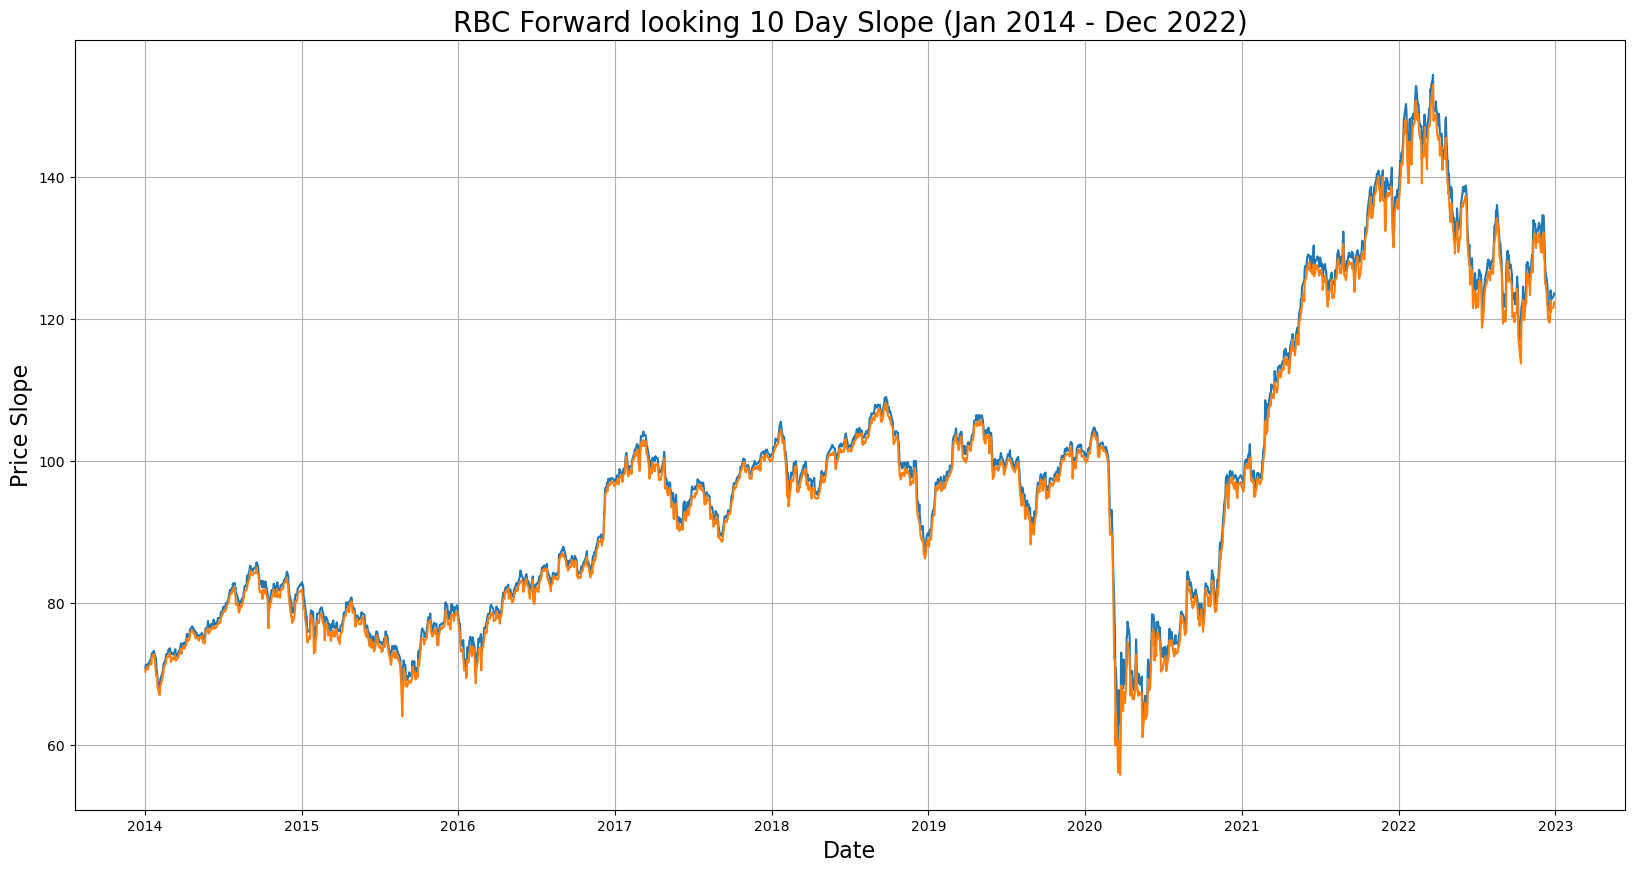

In [4]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['High']], label='High')
plt.plot(df[['Low']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


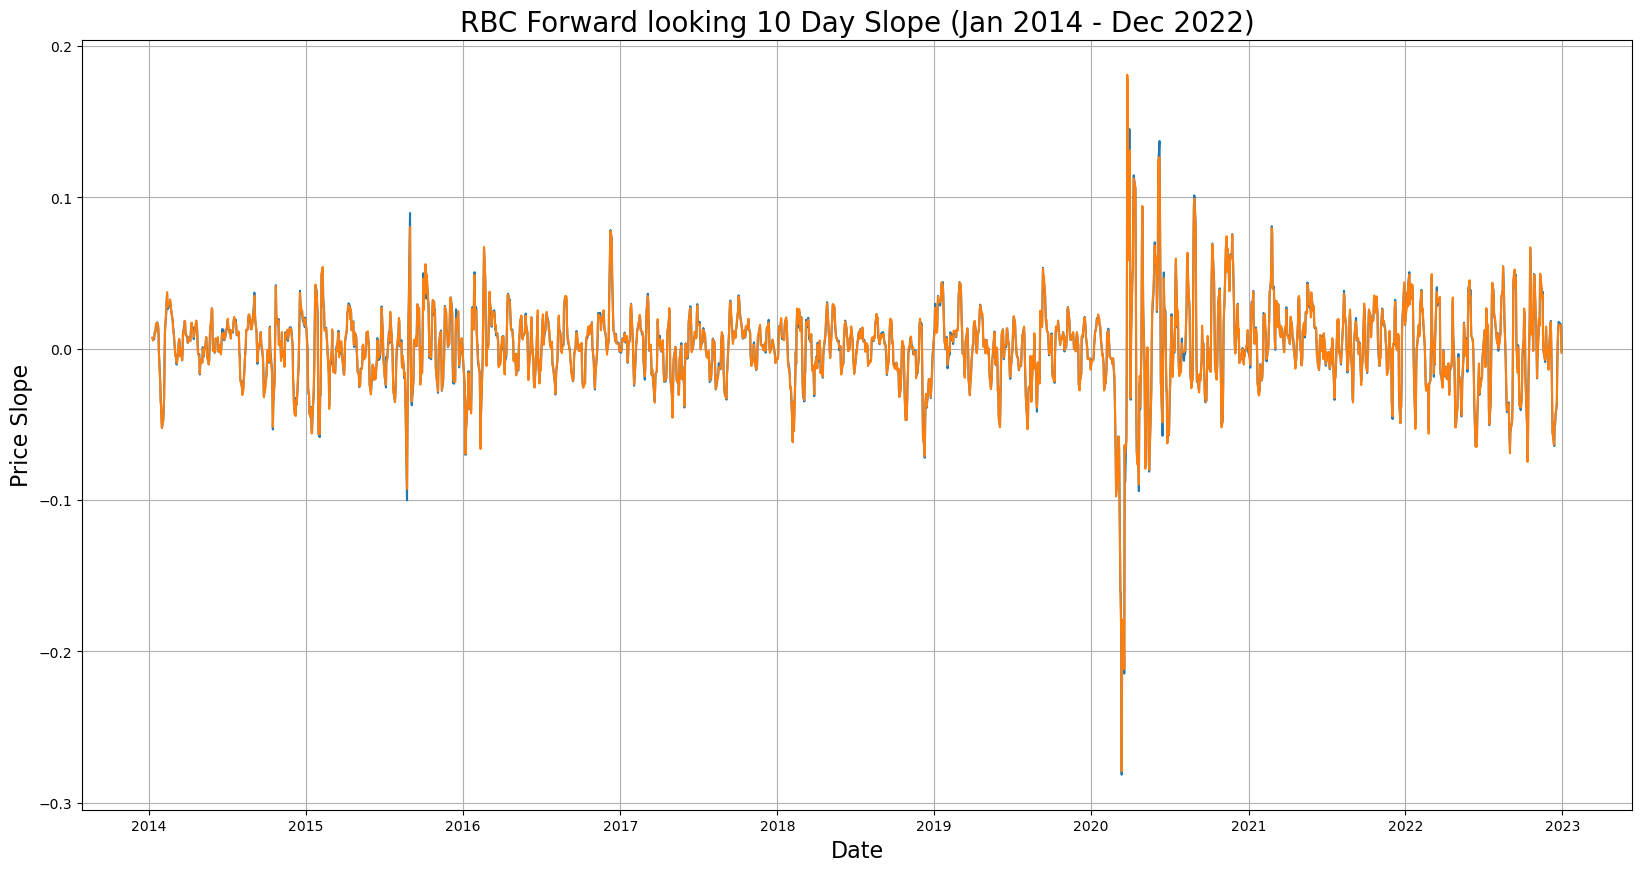

In [5]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Returns_5Day_Moc']], label='Open-Close')
plt.plot(df[['Returns_5Day_Mhloc']], label='High-Low-Open-Close')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


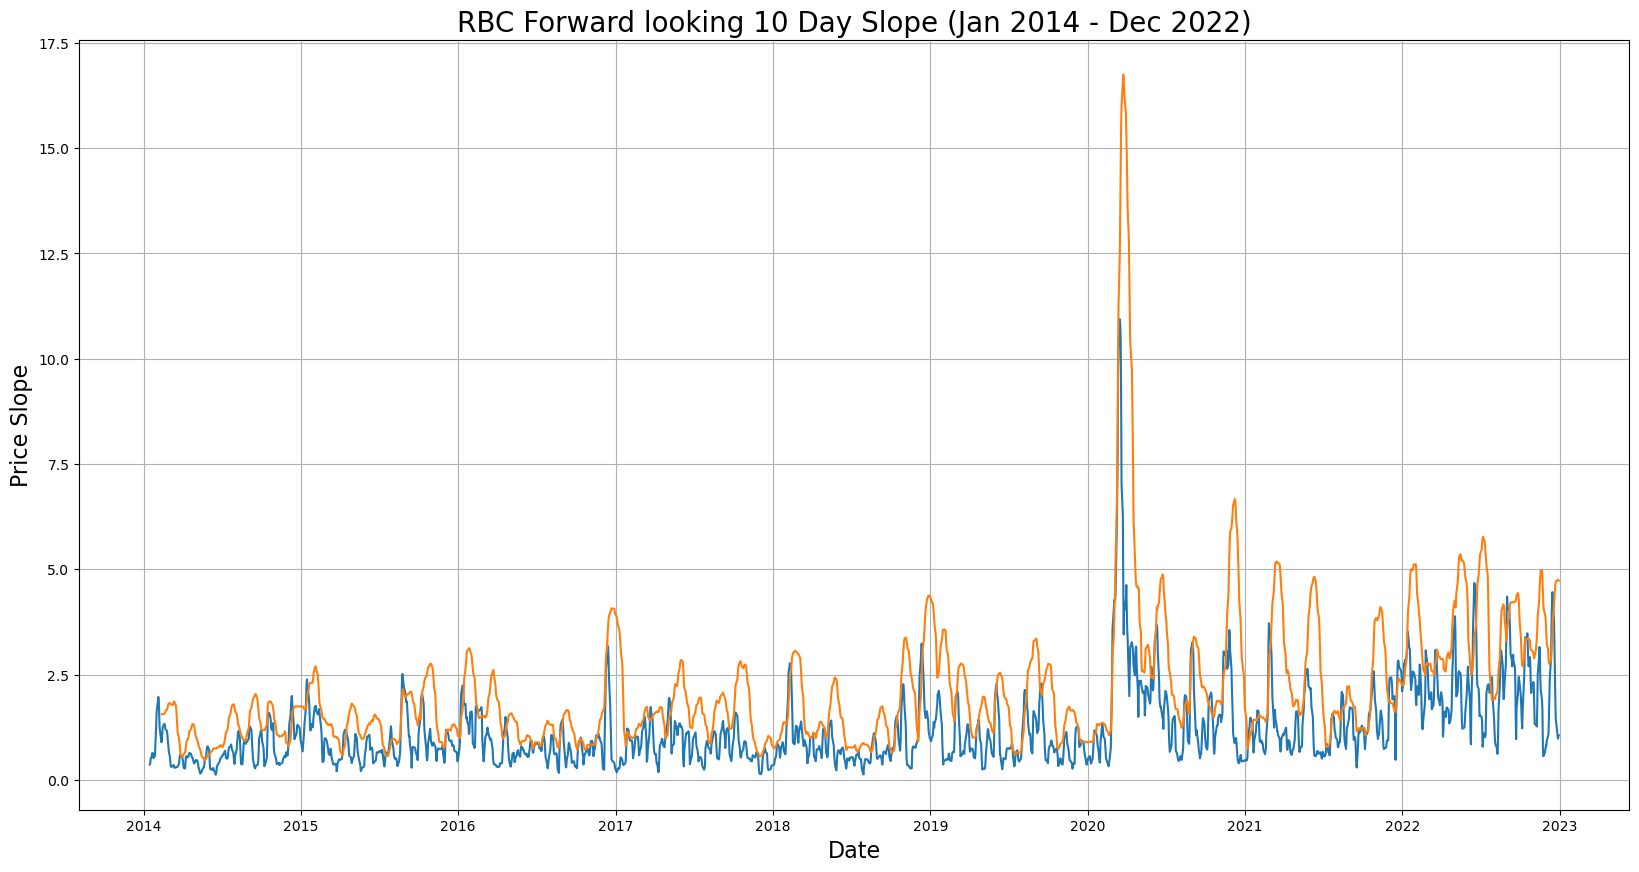

In [6]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Std_Dev_10Day_Moc']], label='High')
plt.plot(df[['Std_Dev_30Day_Moc']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [7]:
# Prepare df for trend determination
df = df.sort_index()
df = df.reset_index()
df

Date        Open        High         Low  \
0    2014-01-02 00:00:00-05:00   70.680000   70.779999   70.300003   
1    2014-01-03 00:00:00-05:00   70.790001   71.250000   70.739998   
2    2014-01-06 00:00:00-05:00   71.279999   71.300003   70.599998   
3    2014-01-07 00:00:00-05:00   71.029999   71.279999   70.940002   
4    2014-01-08 00:00:00-05:00   71.089996   71.220001   70.629997   
...                        ...         ...         ...         ...   
2253 2022-12-22 00:00:00-05:00  122.750000  122.930000  121.029999   
2254 2022-12-23 00:00:00-05:00  122.190002  122.769997  121.580002   
2255 2022-12-28 00:00:00-05:00  122.779999  123.290001  121.650002   
2256 2022-12-29 00:00:00-05:00  122.559998  123.660004  122.440002   
2257 2022-12-30 00:00:00-05:00  122.849998  123.559998  122.230003   

           Close   Adj Close   Volume      Mid_hl      Mid_oc    Mid_hloc  \
0      70.730003   48.488052   983600   70.540001   70.705002   70.622501   
1      71.040001   48.700581  1233400   70.994999   70.915001   70.955000   
2      70.839996   48.563465  1351800   70.950001   71.059998   71.004999   
3      70.940002   48.632042  1035600   71.110001   70.985001   71.047501   
4      71.000000   48.673157  1062000   70.924999   71.044998   70.984999   
...          ...         ...      ...         ...         ...         ...   
2253  122.089996  120.799042  1158300  121.980000  122.419998  122.199999   
2254  122.690002  121.392700  2579100  122.174999  122.440002  122.307501   
2255  122.010002  120.719894  1296200  122.470001  122.395000  122.432501   
2256  123.449997  122.144661  2238800  123.050003  123.004997  123.027500   
2257  122.660004  121.363022   706600  122.895000  122.755001  122.825001   

      ...  Returns_5Day_Mhloc  Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
0     ...                 NaN                  NaN                NaN   
1     ...                 NaN                  NaN                NaN   
2     ...                 NaN                  NaN                NaN   
3     ...                 NaN                  NaN                NaN   
4     ...                 NaN                  NaN                NaN   
...   ...                 ...                  ...                ...   
2253  ...            0.009959            -0.062272           1.862047   
2254  ...            0.015949            -0.076454           1.433345   
2255  ...            0.015616            -0.076330           0.976960   
2256  ...            0.014116            -0.072645           1.032902   
2257  ...           -0.002680            -0.067936           1.056529   

      Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  Std_Dev_30Day_Mhloc  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
...                 ...                  ...                  ...   
2253           4.641628             1.816914             4.594667   
2254           4.709655             1.381815             4.667974   
2255           4.749546             1.015874             4.706217   
2256           4.732547             1.016790             4.694165   
2257           4.729445             1.027896             4.698418   

      SMA_Returns_8Day_Mhloc  SMA_Returns_20Day_Mhloc  \
0                        NaN                      NaN   
1                        NaN                      NaN   
2                        NaN                      NaN   
3                        NaN                      NaN   
4                        NaN                      NaN   
...                      ...                      ...   
2253                0.011020                 0.009882   
2254                0.008044                 0.009903   
2255                0.008046             

In [8]:
# Calculate the 10-day forward looking slope of daily price benchmarks 
# Slope = coefecient from sklearn regression model
# Price Benchmarks = high, low, open, close

# Initialize X variable 1-10 
X = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])

# Initialize results dataframe
df_target_y = pd.DataFrame(columns = ['index', 'high_slope','high_intercept', 'mid_hl_slope', 'mid_hl_intercept', 'mid_oc_slope', 'mid_oc_intercept', 'low_slope', 'low_intercept', 'trend_10day'])

# Calculate from 1st to last less 10 days
for i in range(len(df) - 10):
    
    # Initialize y variables
    trend = 10
    y_High = np.array([])
    y_Mid_hl = np.array([])
    y_Mid_oc = np.array([])
    y_Low = np.array([])
    count = 0
    
    # Calculate y variables and add them to the array
    for j in range (i , i + 10):
        y_High = np.insert(y_High, len(y_High), df['High'].iloc[[j]])
        y_Mid_hl = np.insert(y_Mid_hl, len(y_Mid_hl), (df['High'].iloc[[j]] + df['Low'].iloc[[j]])/2)
        y_Mid_oc = np.insert(y_Mid_oc, len(y_Mid_oc), (df['Open'].iloc[[j]] + df['Close'].iloc[[j]])/2)
        y_Low = np.insert(y_Low, len(y_Low), df['Low'].iloc[[j]])
        count += 1
    
    # Reshape the y array for the regression model   
    y_High = y_High.reshape(-1,1)
    y_Mid_hl = y_Mid_hl.reshape(-1,1)
    y_Mid_oc = y_Mid_oc.reshape(-1,1)
    y_Low = y_Low.reshape(-1,1)
    
    # Regression models
    reg_High = LinearRegression().fit(X, y_High)
    reg_Mid_hl = LinearRegression().fit(X, y_Mid_hl)
    reg_Mid_oc = LinearRegression().fit(X, y_Mid_oc)
    reg_Low = LinearRegression().fit(X, y_Low)
    
    # Determine trend 
    # 0 - Down = 3 negative coefecients or 2 negative and the sum of all 4 is negative
    # 1 - Up   = 3 positive coefecients or 2 positive and the sum of all 4 is positive
    if (reg_High.coef_ > 0 and reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0): 
        trend = 1
    elif (reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ < 0 and reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0):
        trend = 0
    elif (reg_High.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0): 
        trend = 0
    elif (reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0):
        trend = 0
    elif (reg_High.coef_  + reg_Mid_hl.coef_ + reg_Mid_oc.coef_ + reg_Low.coef_ > 0):
        trend = 1    
    else: 
        trend =0
    
    # Populate result dataframe
    df_temp = pd.DataFrame({"index":i,  "high_slope": reg_High.coef_[0],     "high_intercept": reg_High.intercept_[0], 
                                        "mid_hl_slope": reg_Mid_hl.coef_[0], "mid_hl_intercept": reg_Mid_hl.intercept_[0],
                                        "mid_oc_slope": reg_Mid_oc.coef_[0], "mid_oc_intercept": reg_Mid_oc.intercept_[0], 
                                        "low_slope": reg_Low.coef_[0],       "low_intercept": reg_Low.intercept_[0],
                                        "trend_10day": trend})
    
    df_target_y = pd.concat([df_target_y,df_temp], axis = "rows")
    
    #print(f" row {i} xxx High: {reg_High.coef_} xxx Mid HiLo: {reg_Mid_hl.coef_} xxx Mid OpCl: {reg_Mid_oc.coef_} xxx Low: {reg_Low.coef_} xxx {trend}")
    #print('========================')

# Display result Dataframe
df_target_y = df_target_y.set_index(['index'])
display(df_target_y)

C:\Users\jersk\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


high_slope  high_intercept  mid_hl_slope  mid_hl_intercept  \
index                                                               
0        0.124727       70.780000      0.126303         70.512333   
1        0.125576       70.929334      0.115818         70.699000   
2        0.169636       70.850002      0.160121         70.612334   
3        0.200546       70.844000      0.194667         70.606333   
4        0.224424       70.904668      0.226303         70.616333   
...           ...             ...           ...               ...   
2243    -0.669576      127.904669     -0.584061        126.338334   
2244    -0.405515      125.821333     -0.379636        124.699000   
2245    -0.244364      124.544000     -0.182152        123.237333   
2246    -0.078788      123.401332     -0.010060        122.075332   
2247     0.107758      122.221332      0.151121        121.134333   

       mid_oc_slope  mid_oc_intercept  low_slope  low_intercept trend_10day  
index                                                                        
0          0.116394         70.593334   0.127879      70.244667           1  
1          0.123788         70.683666   0.106061      70.468666           1  
2          0.153030         70.676332   0.150606      70.374666           1  
3          0.189970         70.642666   0.188788      70.368666           1  
4          0.206545         70.737999   0.228182      70.327998           1  
...             ...               ...        ...            ...         ...  
2243      -0.623788        126.321332  -0.498545     124.771999           0  
2244      -0.354818        124.352999  -0.353758     123.576667           0  
2245      -0.125818        122.756997  -0.119939     121.930666           0  
2246       0.095182        121.269998   0.058667     120.749333           1  
2247       0.204697        120.723665   0.194485     120.047333           1  

[2248 rows x 9 columns]

In [9]:
df = pd.concat([df, df_target_y], axis= 1)
display(df.head(11))
display(df.tail(11))

Date       Open       High        Low      Close  \
0  2014-01-02 00:00:00-05:00  70.680000  70.779999  70.300003  70.730003   
1  2014-01-03 00:00:00-05:00  70.790001  71.250000  70.739998  71.040001   
2  2014-01-06 00:00:00-05:00  71.279999  71.300003  70.599998  70.839996   
3  2014-01-07 00:00:00-05:00  71.029999  71.279999  70.940002  70.940002   
4  2014-01-08 00:00:00-05:00  71.089996  71.220001  70.629997  71.000000   
5  2014-01-09 00:00:00-05:00  71.199997  71.370003  70.769997  71.209999   
6  2014-01-10 00:00:00-05:00  71.389999  71.519997  71.099998  71.349998   
7  2014-01-13 00:00:00-05:00  71.300003  71.879997  71.300003  71.699997   
8  2014-01-14 00:00:00-05:00  71.910004  71.980003  71.519997  71.599998   
9  2014-01-15 00:00:00-05:00  71.849998  72.080002  71.580002  71.739998   
10 2014-01-16 00:00:00-05:00  71.769997  72.320000  71.339996  72.260002   

    Adj Close   Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
0   48.488052   983600  70.540001  70.705002  70.622501  ...   
1   48.700581  1233400  70.994999  70.915001  70.955000  ...   
2   48.563465  1351800  70.950001  71.059998  71.004999  ...   
3   48.632042  1035600  71.110001  70.985001  71.047501  ...   
4   48.673157  1062000  70.924999  71.044998  70.984999  ...   
5   48.817116   914600  71.070000  71.204998  71.137499  ...   
6   48.913097  1378900  71.309998  71.369999  71.339998  ...   
7   49.153030  1122400  71.590000  71.500000  71.545000  ...   
8   49.084488  1020900  71.750000  71.755001  71.752501  ...   
9   49.180443  1141500  71.830002  71.794998  71.812500  ...   
10  49.536934  1276200  71.829998  72.014999  71.922499  ...   

    SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
0                          1    0.124727       70.780000      0.126303   
1                          1    0.125576       70.929334      0.115818   
2                          1    0.169636       70.850002      0.160121   
3                          1    0.200546       70.844000      0.194667   
4                          1    0.224424       70.904668      0.226303   
5                          1    0.222667       71.115333      0.222758   
6                          1    0.191818       71.443999      0.198455   
7                          1    0.137515       71.860667      0.136363   
8                          0    0.053636       72.332001      0.011909   
9                          0   -0.089697       73.001333     -0.135909   
10                         0   -0.234303       73.626666     -0.264939   

    mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
0          70.512333      0.116394         70.593334   0.127879   
1          70.699000      0.123788         70.683666   0.106061   
2          70.612334      0.153030         70.676332   0.150606   
3          70.606333      0.189970         70.642666   0.188788   
4          70.616333      0.206545         70.737999   0.228182   
5          70.837332      0.207788         70.917666   0.222849   
6          71.146999      0.187818         71.180999   0.205091   
7          71.581001      0.133515         71.567666   0.135212   
8          72.202000      0.021030         72.158332  -0.029818   
9          72.859000     -0.110606         72.756332  -0.182121   
10         73.394665     -0.244212         73.324666  -0.295576   

    low_intercept  trend_10day  
0       70.244667            1  
1       70.468666            1  
2       70.374666            1  
3       70.368666            1  
4       70.327998            1  
5       70.559332            1  
6       70.850000            1  
7       71.301334            1  
8       72.071999            1  
9       72.716667            0  
10      73.162664            0  

[11 rows x 34 columns]

Date        Open        High         Low  \
2247 2022-12-14 00:00:00-05:00  122.599998  124.089996  121.820000   
2248 2022-12-15 00:00:00-05:00  121.070000  122.080002  120.080002   
2249 2022-12-16 00:00:00-05:00  119.959999  121.160004  119.800003   
2250 2022-12-19 00:00:00-05:00  120.779999  121.809998  119.519997   
2251 2022-12-20 00:00:00-05:00  120.709999  122.290001  120.580002   
2252 2022-12-21 00:00:00-05:00  122.779999  124.059998  122.669998   
2253 2022-12-22 00:00:00-05:00  122.750000  122.930000  121.029999   
2254 2022-12-23 00:00:00-05:00  122.190002  122.769997  121.580002   
2255 2022-12-28 00:00:00-05:00  122.779999  123.290001  121.650002   
2256 2022-12-29 00:00:00-05:00  122.559998  123.660004  122.440002   
2257 2022-12-30 00:00:00-05:00  122.849998  123.559998  122.230003   

           Close   Adj Close   Volume      Mid_hl      Mid_oc    Mid_hloc  \
2247  122.309998  121.016716  1559100  122.954998  122.454998  122.704998   
2248  120.750000  119.473213  2053100  121.080002  120.910000  120.995001   
2249  120.629997  119.354477  5149500  120.480003  120.294998  120.387501   
2250  120.089996  118.820190  2572500  120.664997  120.434998  120.549997   
2251  121.680000  120.393379  2141400  121.435001  121.195000  121.315001   
2252  123.110001  121.808258  1803600  123.364998  122.945000  123.154999   
2253  122.089996  120.799042  1158300  121.980000  122.419998  122.199999   
2254  122.690002  121.392700  2579100  122.174999  122.440002  122.307501   
2255  122.010002  120.719894  1296200  122.470001  122.395000  122.432501   
2256  123.449997  122.144661  2238800  123.050003  123.004997  123.027500   
2257  122.660004  121.363022   706600  122.895000  122.755001  122.825001   

      ...  SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
2247  ...                         0    0.107758      122.221332      0.151121   
2248  ...                         0         NaN             NaN           NaN   
2249  ...                         0         NaN             NaN           NaN   
2250  ...                         0         NaN             NaN           NaN   
2251  ...                         0         NaN             NaN           NaN   
2252  ...                         0         NaN             NaN           NaN   
2253  ...                         0         NaN             NaN           NaN   
2254  ...                         0         NaN             NaN           NaN   
2255  ...                         0         NaN             NaN           NaN   
2256  ...                         0         NaN             NaN           NaN   
2257  ...                         0         NaN             NaN           NaN   

      mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
2247        121.134333      0.204697        120.723665   0.194485   
2248               NaN           NaN               NaN        NaN   
2249               NaN           NaN               NaN        NaN   
2250               NaN           NaN               NaN        NaN   
2251               NaN           NaN               NaN        NaN   
2252               NaN           NaN               NaN        NaN   
2253               NaN           NaN               NaN        NaN   
2254               NaN           NaN               NaN        NaN   
2255               NaN           NaN               NaN        NaN   
2256               NaN           NaN               NaN        NaN   
2257               NaN           NaN               NaN        NaN   

      low_intercept  trend_10day  
2247     120.047333            1  
2248            NaN          NaN  
2249            NaN          NaN  
2250            NaN          NaN  
2251            NaN          NaN  
2252            NaN          NaN  
2253            NaN          NaN  
2254            NaN          NaN  
2255            NaN          NaN  
2256            NaN          NaN  
2257            NaN          NaN  

[11 rows x 34 columns]

In [10]:
df = df.set_index(['Date'])
display(df.head(11))
display(df.tail(11))


Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  70.680000  70.779999  70.300003  70.730003   
2014-01-03 00:00:00-05:00  70.790001  71.250000  70.739998  71.040001   
2014-01-06 00:00:00-05:00  71.279999  71.300003  70.599998  70.839996   
2014-01-07 00:00:00-05:00  71.029999  71.279999  70.940002  70.940002   
2014-01-08 00:00:00-05:00  71.089996  71.220001  70.629997  71.000000   
2014-01-09 00:00:00-05:00  71.199997  71.370003  70.769997  71.209999   
2014-01-10 00:00:00-05:00  71.389999  71.519997  71.099998  71.349998   
2014-01-13 00:00:00-05:00  71.300003  71.879997  71.300003  71.699997   
2014-01-14 00:00:00-05:00  71.910004  71.980003  71.519997  71.599998   
2014-01-15 00:00:00-05:00  71.849998  72.080002  71.580002  71.739998   
2014-01-16 00:00:00-05:00  71.769997  72.320000  71.339996  72.260002   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  48.488052   983600  70.540001  70.705002   
2014-01-03 00:00:00-05:00  48.700581  1233400  70.994999  70.915001   
2014-01-06 00:00:00-05:00  48.563465  1351800  70.950001  71.059998   
2014-01-07 00:00:00-05:00  48.632042  1035600  71.110001  70.985001   
2014-01-08 00:00:00-05:00  48.673157  1062000  70.924999  71.044998   
2014-01-09 00:00:00-05:00  48.817116   914600  71.070000  71.204998   
2014-01-10 00:00:00-05:00  48.913097  1378900  71.309998  71.369999   
2014-01-13 00:00:00-05:00  49.153030  1122400  71.590000  71.500000   
2014-01-14 00:00:00-05:00  49.084488  1020900  71.750000  71.755001   
2014-01-15 00:00:00-05:00  49.180443  1141500  71.830002  71.794998   
2014-01-16 00:00:00-05:00  49.536934  1276200  71.829998  72.014999   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2014-01-02 00:00:00-05:00  70.622501        0.895842  ...   
2014-01-03 00:00:00-05:00  70.955000        0.588239  ...   
2014-01-06 00:00:00-05:00  71.004999        0.342852  ...   
2014-01-07 00:00:00-05:00  71.047501        0.000000  ...   
2014-01-08 00:00:00-05:00  70.984999        0.627119  ...   
2014-01-09 00:00:00-05:00  71.137499        0.733330  ...   
2014-01-10 00:00:00-05:00  71.339998        0.595241  ...   
2014-01-13 00:00:00-05:00  71.545000        0.689652  ...   
2014-01-14 00:00:00-05:00  71.752501        0.173914  ...   
2014-01-15 00:00:00-05:00  71.812500        0.319992  ...   
2014-01-16 00:00:00-05:00  71.922499        0.938778  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2014-01-02 00:00:00-05:00                         1    0.124727   
2014-01-03 00:00:00-05:00                         1    0.125576   
2014-01-06 00:00:00-05:00                         1    0.169636   
2014-01-07 00:00:00-05:00                         1    0.200546   
2014-01-08 00:00:00-05:00                         1    0.224424   
2014-01-09 00:00:00-05:00                         1    0.222667   
2014-01-10 00:00:00-05:00                         1    0.191818   
2014-01-13 00:00:00-05:00                         1    0.137515   
2014-01-14 00:00:00-05:00                         0    0.053636   
2014-01-15 00:00:00-05:00                         0   -0.089697   
2014-01-16 00:00:00-05:00                         0   -0.234303   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2014-01-02 00:00:00-05:00       70.780000      0.126303         70.512333   
2014-01-03 00:00:00-05:00       70.929334      0.115818         70.699000   
2014-01-06 00:00:00-05:00       70.850002      0.160121         70.612334   
2014-01-07 00:00:00-05:00       70.844000      0.194667         70.606333   
2014-01-08 00:00:00-05:00     

Open        High         Low       Close  \
Date                                                                        
2022-12-14 00:00:00-05:00  122.599998  124.089996  121.820000  122.309998   
2022-12-15 00:00:00-05:00  121.070000  122.080002  120.080002  120.750000   
2022-12-16 00:00:00-05:00  119.959999  121.160004  119.800003  120.629997   
2022-12-19 00:00:00-05:00  120.779999  121.809998  119.519997  120.089996   
2022-12-20 00:00:00-05:00  120.709999  122.290001  120.580002  121.680000   
2022-12-21 00:00:00-05:00  122.779999  124.059998  122.669998  123.110001   
2022-12-22 00:00:00-05:00  122.750000  122.930000  121.029999  122.089996   
2022-12-23 00:00:00-05:00  122.190002  122.769997  121.580002  122.690002   
2022-12-28 00:00:00-05:00  122.779999  123.290001  121.650002  122.010002   
2022-12-29 00:00:00-05:00  122.559998  123.660004  122.440002  123.449997   
2022-12-30 00:00:00-05:00  122.849998  123.559998  122.230003  122.660004   

                            Adj Close   Volume      Mid_hl      Mid_oc  \
Date                                                                     
2022-12-14 00:00:00-05:00  121.016716  1559100  122.954998  122.454998   
2022-12-15 00:00:00-05:00  119.473213  2053100  121.080002  120.910000   
2022-12-16 00:00:00-05:00  119.354477  5149500  120.480003  120.294998   
2022-12-19 00:00:00-05:00  118.820190  2572500  120.664997  120.434998   
2022-12-20 00:00:00-05:00  120.393379  2141400  121.435001  121.195000   
2022-12-21 00:00:00-05:00  121.808258  1803600  123.364998  122.945000   
2022-12-22 00:00:00-05:00  120.799042  1158300  121.980000  122.419998   
2022-12-23 00:00:00-05:00  121.392700  2579100  122.174999  122.440002   
2022-12-28 00:00:00-05:00  120.719894  1296200  122.470001  122.395000   
2022-12-29 00:00:00-05:00  122.144661  2238800  123.050003  123.004997   
2022-12-30 00:00:00-05:00  121.363022   706600  122.895000  122.755001   

                             Mid_hloc  Close_in_range  ...  \
Date                                                   ...   
2022-12-14 00:00:00-05:00  122.704998        0.215858  ...   
2022-12-15 00:00:00-05:00  120.995001        0.334999  ...   
2022-12-16 00:00:00-05:00  120.387501        0.610290  ...   
2022-12-19 00:00:00-05:00  120.549997        0.248908  ...   
2022-12-20 00:00:00-05:00  121.315001        0.643274  ...   
2022-12-21 00:00:00-05:00  123.154999        0.316549  ...   
2022-12-22 00:00:00-05:00  122.199999        0.557893  ...   
2022-12-23 00:00:00-05:00  122.307501        0.932778  ...   
2022-12-28 00:00:00-05:00  122.432501        0.219513  ...   
2022-12-29 00:00:00-05:00  123.027500        0.827864  ...   
2022-12-30 00:00:00-05:00  122.825001        0.323310  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2022-12-14 00:00:00-05:00                         0    0.107758   
2022-12-15 00:00:00-05:00                         0         NaN   
2022-12-16 00:00:00-05:00                         0         NaN   
2022-12-19 00:00:00-05:00                         0         NaN   
2022-12-20 00:00:00-05:00                         0         NaN   
2022-12-21 00:00:00-05:00                         0         NaN   
2022-12-22 00:00:00-05:00                         0         NaN   
2022-12-23 00:00:00-05:00                         0         NaN   
2022-12-28 00:00:00-05:00                         0         NaN   
2022-12-29 00:00:00-05:00                         0         NaN   
2022-12-30 00:00:00-05:00                         0         NaN   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2022-12-14 00:00:00-05:00      122.221332      0.151121        121.134333   
2022-12-15 00:00:00-05:00             NaN           NaN               NaN   
2022-12-16 00:00:00-05:00             NaN           NaN               NaN   
2022

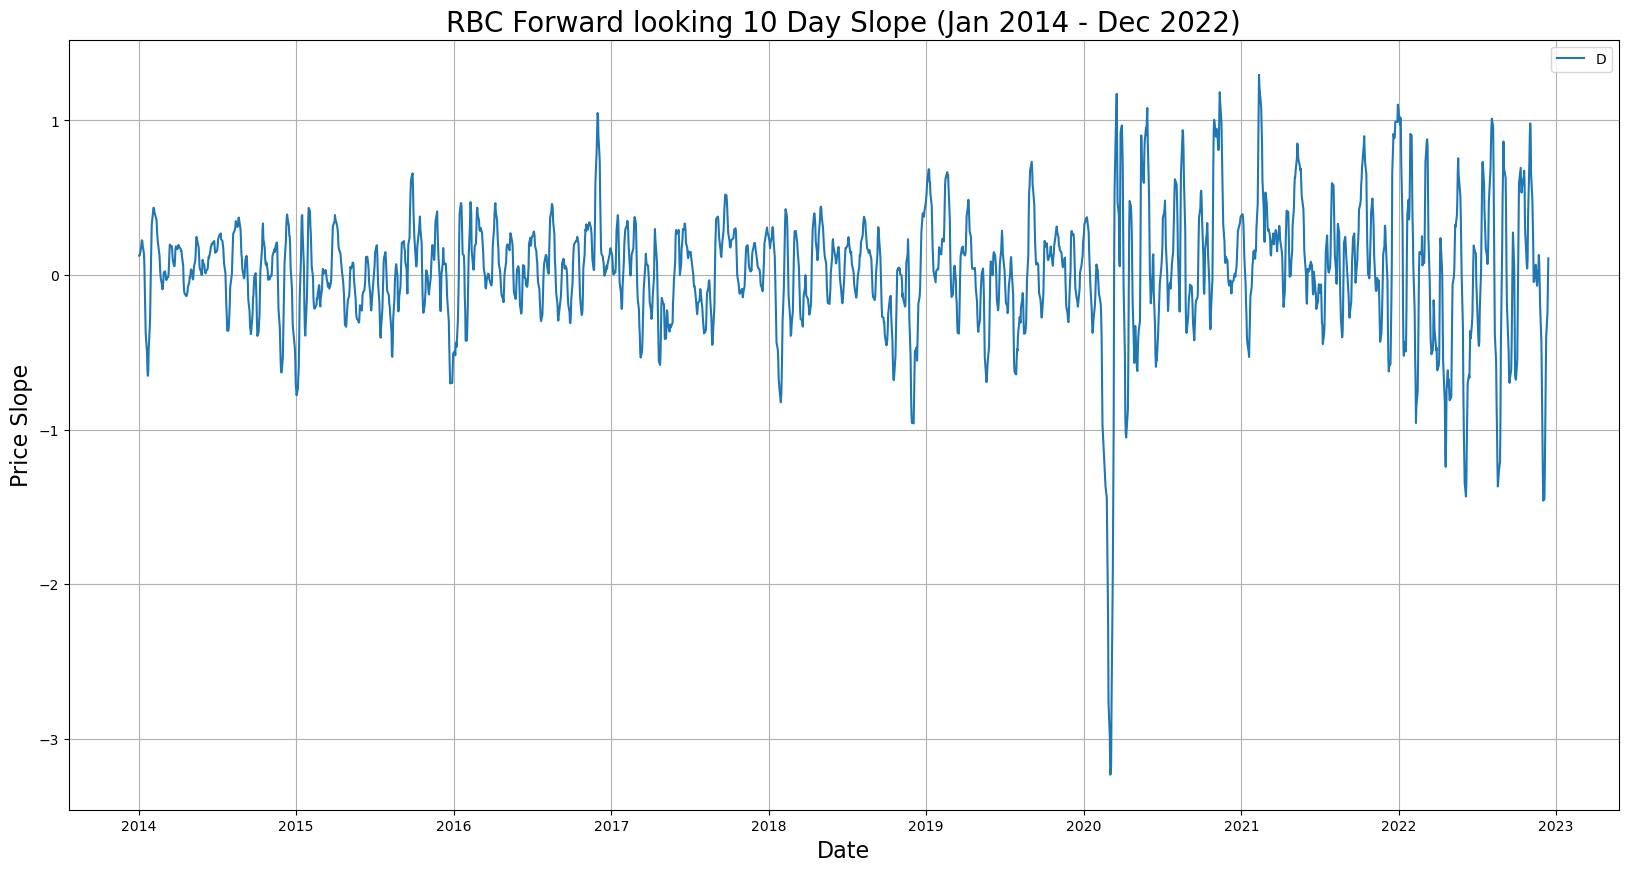

In [11]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['high_slope']])
#plt.title("Bank of Montreal (BMO) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend('Daily High')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [12]:
df.to_csv('../Data/Feature_Engineering_BMO.csv', encoding='utf-8')